#  Edge Graph Convolutional NN for Jet anomaly (variational) autoencoder  using jet constituents from offline delphes data


In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import setGPU
from importlib import reload

setGPU: Setting GPU to: 0


In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import models.models as models
reload(models)
import models.losses as losses
reload(losses)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [3]:
#Data Samples
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
batch_size = 128
train_set_size = int((5*10e3//batch_size)*batch_size)

In [4]:
nodes_n, feat_sz, particles_bg  = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)

# BG validation
VALID_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband'
filename_bg_valid = DATA_PATH + VALID_NAME + '_parts/' + VALID_NAME + '_000.h5'
valid_set_size = int((10e4//batch_size)*batch_size)
_,_, particles_bg_valid = prepr.prepare_data_constituents(filename_bg,valid_set_size,0,valid_set_size+1)



Number of jets = 98135
Number of constituents (nodes) = 20
Number of features = 3
Number of jets = 196521
Number of constituents (nodes) = 20
Number of features = 3


In [5]:
#BG test
_,_, particles_bg_test = prepr.prepare_data_constituents(filename_bg,5000,train_set_size+1,train_set_size+5000)


Number of jets = 9849
Number of constituents (nodes) = 20
Number of features = 3


In [6]:
#signal
SIG_MASS = '3.5'
SIG_NAME = 'RSGraviton_WW_NARROW_13TeV_PU40_'+SIG_MASS+'TeV_NEW'
filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
_,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)

Number of jets = 9966
Number of constituents (nodes) = 20
Number of features = 3


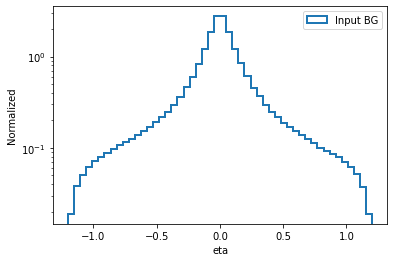

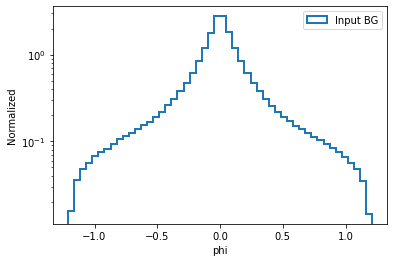

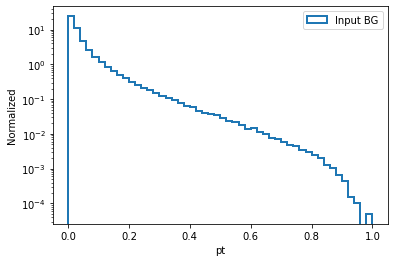

In [7]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

## Define KNN algorithm to find nearest node neightbours 

In [8]:


# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(num_points, k, topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)


def knn_diff(X,K):
    """EdgeConv
    Args:
        K: int, number of neighbors
    Inputs:
        X: point features (eta, phi, Pt)
    Returns:
        neighbours features differences
    """

    # Define node coordinates and features ( original ParticleNET uses only Pt as node features ! )
    pts = X[:,:,1:3] # (Eta,Phi) coordinates of points ( graph nodes )
    fts = X          # (Pt,Eta,Phi) node features ( graph node features )
    num_points = X.shape[1]

    # distance
    D = batch_distance_matrix_general(pts, pts)  # (N, P, P)
    _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)
    indices = indices[:, :, 1:]  # (N, P, K)

    # Finds nodes nearest neighbours features differences
    knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
    knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  
    knn_fts = tf.subtract(knn_fts, knn_fts_center)  # (N, P, K, C)

    return knn_fts



## Define EdgeGraphConv Model 

EdgeGraphConv implements a modified version of DGCNN where we use a Conv1D instead of a Conv2D in order to define the convolution over the graph nodes and edges. Notice that a Conv1D layer uses a kernel_size=1 and stride=1 over the nodes(edges), so it's equivalent to apply a MLP to agregate the  nodes(edges) features. In Spektral EdgeConv uses directly an MLP for that. 

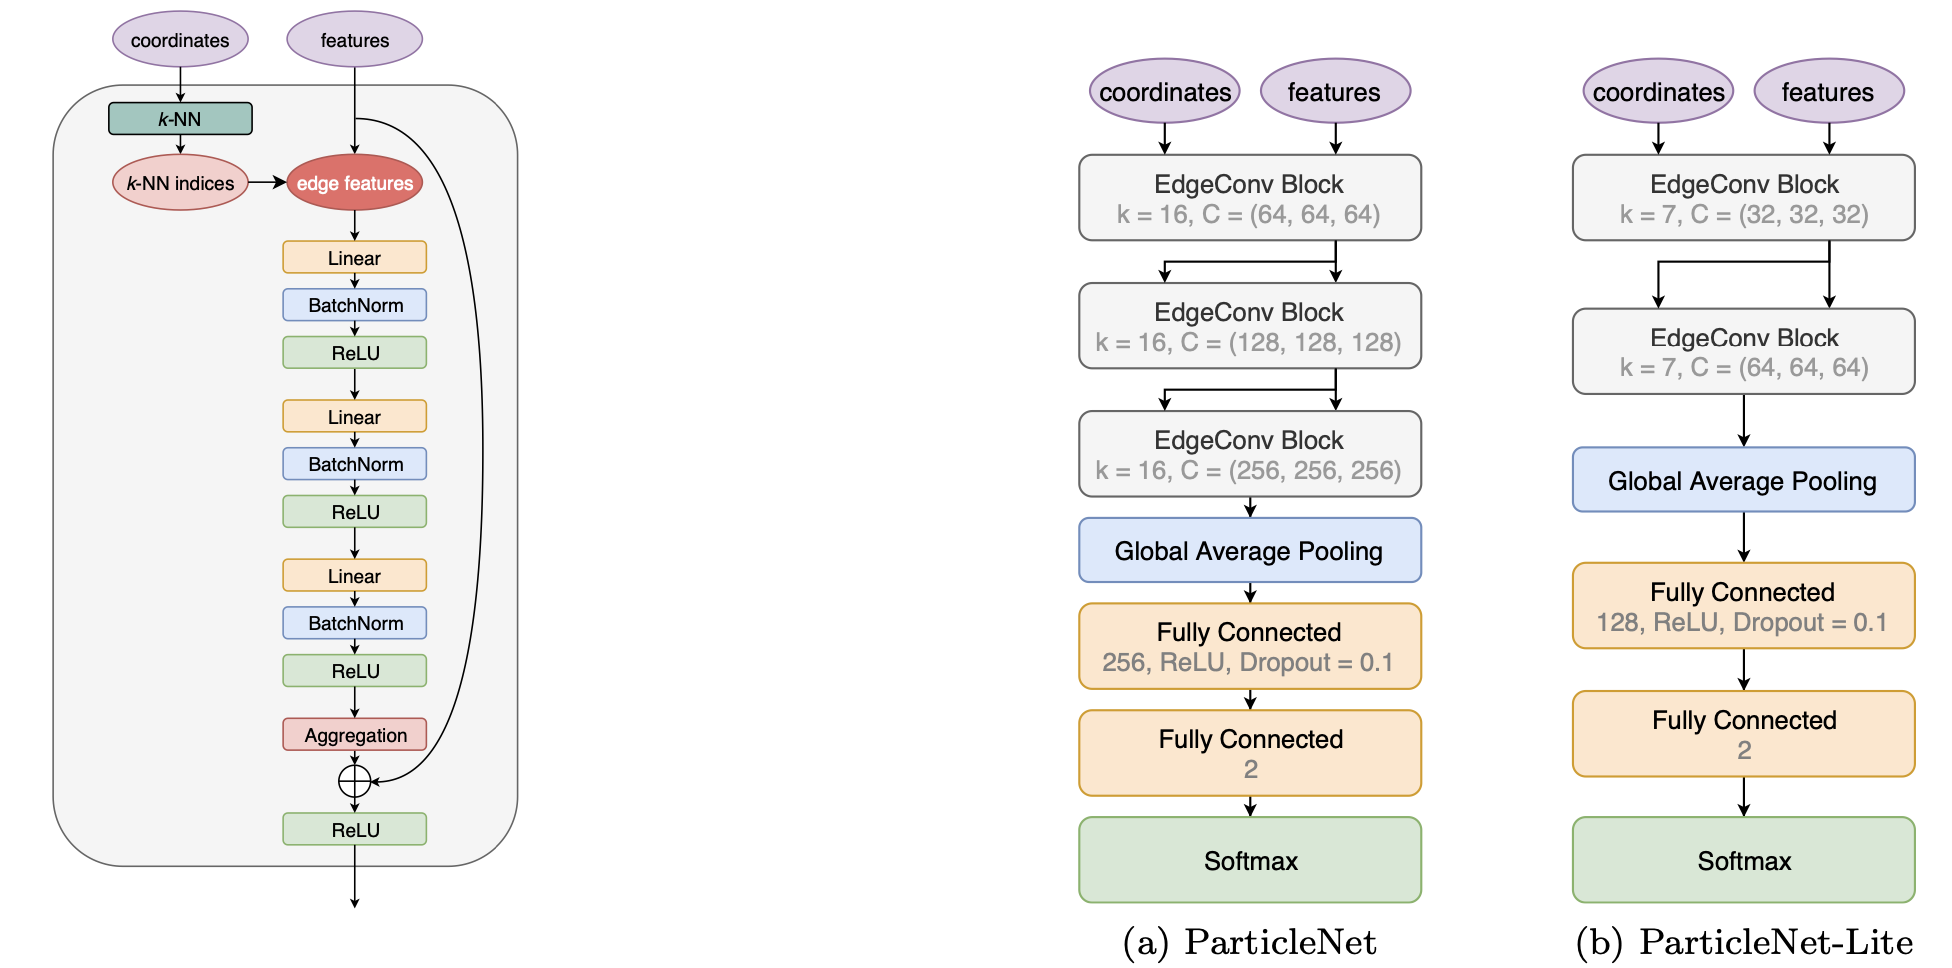


In [9]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, Conv1D
from tensorflow.keras.layers import Input, Activation, Dense, Flatten , LeakyReLU
from tensorflow.keras import utils

import models.layers as lays
reload(lays)

###########################################################################
# Define GraphConv Model 

point_channels = 20    #20 
edge_channels  = 20    #20
nhidden = int(nodes_n*feat_sz/2) 

k=15                   
#'''

##############################################################################

# Instantiate Tensorflow input tensors in Batch mode 
in_points = Input(shape=(nodes_n,feat_sz), name="in_points")

# Input point features BatchNormalization 
h = BatchNormalization(name='BatchNorm_points')(in_points)

# Conv1D with kernel_size=nfeatures to implement a MLP like aggregation of 
#   input point features ( pt, eta_rel, phi_rel)

h_points = Conv1D(point_channels, kernel_size=1, strides=1
                  , activation=LeakyReLU(alpha=0.3)
                  , use_bias="True"
                  , name='Conv1D_points')(h) #can be substituted with graph conv layer,
                                            #because this is only fully conencted, e.g. zeros will be connected as well
    

# Instantiate Tensorflow input tensors in Batch mode 
in_edges = Input(shape=(nodes_n,k*feat_sz), name="in_edges")


# Input edges features BatchNormalization 
h = BatchNormalization(name='BatchNorm_edges')(in_edges)


h_edges  = Conv1D(edge_channels, kernel_size=1, strides=1
                  , activation=LeakyReLU(alpha=0.3)
                  , use_bias="True"
                  , name='Conv1D_edges')(h)

# Concatenate points+edge features                           
#        out = Activation(activation, name='Activation_features')(sc + fts)  # (N, P, C')
#        out = sc+fts
h = tf.concat([h_points,h_edges],axis=2)


# Flatten to format for MLP input
h=Flatten(name='Flatten')(h)
print("MLP input h =",h)

#########################Autoencoder#################
#hidden = Dense(nhidden, name = 'hidden',activation=LeakyReLU(alpha=0.3) )(h)

#h = Dense((point_channels+edge_channels)*nodes_n,activation=LeakyReLU(alpha=0.3) )(hidden)
#h = layers.Reshape((nodes_n,point_channels+edge_channels), input_shape=((point_channels+edge_channels)*nodes_n,))(h) 

#out = Conv1D(3, kernel_size=1, strides=1
#                  , activation=LeakyReLU(alpha=0.3)
#                  , use_bias="True"
#                  , name='Conv1D_out')(h)

#model = Model(inputs=[in_points,in_edges], outputs=out,name='ae')
#model.summary()


##########################################################


################### VAE ##################################

# Dense layers for VAE, this whole part (+abvoe) is encoder
z_mean = Dense(nhidden, name = 'z_mean',activation='relu' )(h)
z_log_var = Dense(nhidden, name='z_log_var', activation='relu' )(h)
batch = tf.shape(z_mean)[0]
dim = tf.shape(z_mean)[1]
epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
encoder = tf.keras.Model(inputs=[in_points,in_edges], outputs=[z, z_mean, z_log_var])
encoder.summary()

# Defining decoder
d_i   = Input(shape=(nhidden, ), name='decoder_input')
h = Dense((point_channels+edge_channels)*nodes_n,activation=LeakyReLU(alpha=0.3) )(d_i)
h = layers.Reshape((nodes_n,point_channels+edge_channels), input_shape=((point_channels+edge_channels)*nodes_n,))(h) 
o = Conv1D(3, kernel_size=1, strides=1
                  , activation=LeakyReLU(alpha=0.3)
                  , use_bias="True"
                  , name='Conv1D_out')(h)
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

# Build VAE model
out = decoder(encoder([in_points,in_edges])[0]) #taking z, as encoder returns 3 outputs
model = Model(inputs=[in_points,in_edges], outputs=out,name='vae')
model.summary()

##########################################################






MLP input h = Tensor("Flatten/Reshape:0", shape=(None, 800), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_points (InputLayer)          [(None, 20, 3)]      0                                            
__________________________________________________________________________________________________
in_edges (InputLayer)           [(None, 20, 45)]     0                                            
__________________________________________________________________________________________________
BatchNorm_points (BatchNormaliz (None, 20, 3)        12          in_points[0][0]                  
__________________________________________________________________________________________________
BatchNorm_edges (BatchNormaliza (None, 20, 45)       180         in_edges[0][0]                   
___________

In [34]:
import models.models as models
reload(models)
nhidden = int(nodes_n*feat_sz/4) 

ae = models.EdgeConvAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=LeakyReLU(alpha=0.3),latent_dim=nhidden)

here
Model: "EdgeConvAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_points (InputLayer)          [(None, 20, 3)]      0                                            
__________________________________________________________________________________________________
in_edges (InputLayer)           [(None, 20, 45)]     0                                            
__________________________________________________________________________________________________
BatchNorm_points (BatchNormaliz (None, 20, 3)        12          in_points[0][0]                  
__________________________________________________________________________________________________
BatchNorm_edges (BatchNormaliza (None, 20, 45)       180         in_edges[0][0]                   
____________________________________________________________________________________

In [35]:
def vae_loss(inputs, outputs):
    # Reconstruction loss
    loss_reco = tf.math.reduce_mean(losses.threeD_loss(inputs, outputs))
    loss_latent = tf.math.reduce_mean(losses.kl_loss(z_mean, z_log_var))
    # Total loss = 50% rec + 50% KL divergence loss
    return loss_reco+loss_latent

## Run training
Here, we run the training.

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import setGPU 


optim = Adam(learning_rate=0.001)

ae.compile(optimizer=optim, run_eagerly=True)



# Compile the Model
#model.compile(optimizer=optim, loss=threeD_loss)
#model.compile(optimizer=optim, loss=vae_loss)

# print the model summary
#model.summary()

                    

In [ ]:
# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('EdgeGraphConv_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

# Training data 
diffs_train = knn_diff(particles_bg,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_train = tf.reshape(diffs_train,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat)

# Validation data 
diffs_valid = knn_diff(particles_bg_valid,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_valid = tf.reshape(diffs_valid,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat)

print("point_feats shape= ",particles_bg.shape)
print("edge_feats shape= ",edge_feats_train.shape)

history = ae.fit((particles_bg, edge_feats_train) , particles_bg,
                    validation_data = ((particles_bg_valid, edge_feats_valid) , particles_bg_valid),
                    epochs=100, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls,chkp]) 



#history = model.fit(  [particles_bg, edge_feats_train] , particles_bg,
#                    validation_data = ([particles_bg_valid, edge_feats_valid] , particles_bg_valid),
#                    epochs=100, 
#                    batch_size=512, 
#                    verbose=1,
#                    callbacks=[es,ls,chkp])

point_feats shape=  (49920, 20, 3)
edge_feats shape=  (49920, 20, 45)
Epoch 1/100
98/98 [==============================] - 4s 43ms/step - val_loss: 0.0664
Epoch 2/100
98/98 [==============================] - 4s 38ms/step - val_loss: 0.0584
Epoch 3/100
98/98 [==============================] - 4s 37ms/step - val_loss: 0.0527
Epoch 4/100
98/98 [==============================] - 4s 41ms/step - val_loss: 0.0497
Epoch 5/100
98/98 [==============================] - 4s 40ms/step - val_loss: 0.0487
Epoch 6/100
98/98 [==============================] - 4s 39ms/step - val_loss: 0.0474
Epoch 7/100
98/98 [==============================] - 4s 39ms/step - val_loss: 0.0474
Epoch 8/100
98/98 [==============================] - 4s 37ms/step - val_loss: 0.0465
Epoch 9/100
98/98 [==============================] - 4s 40ms/step - val_loss: 0.0456
Epoch 10/100
98/98 [==============================] - 4s 38ms/step - val_loss: 0.0451
Epoch 11/100
98/98 [==============================] - 4s 39ms/step - val_loss: 

In [30]:
diffs_bg_test = knn_diff(particles_bg_test,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_bg_test = tf.reshape(diffs_bg_test,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat)
Y_bg_predict = model.predict([particles_bg_test,edge_feats_bg_test])

diffs_sig = knn_diff(particles_sig,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_sig = tf.reshape(diffs_sig,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat)
Y_sig_predict = model.predict([particles_sig,edge_feats_sig])

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

In [32]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)

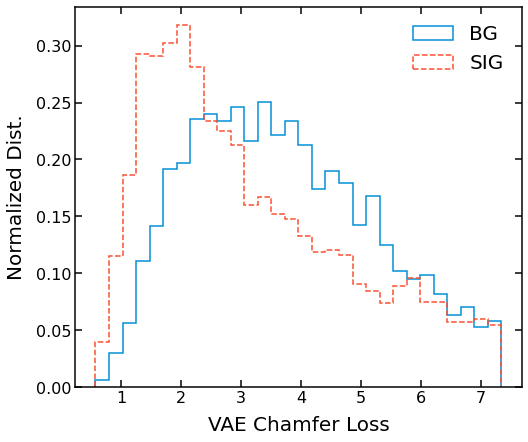

In [33]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_bg,0.95)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_sig, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
plt.show()

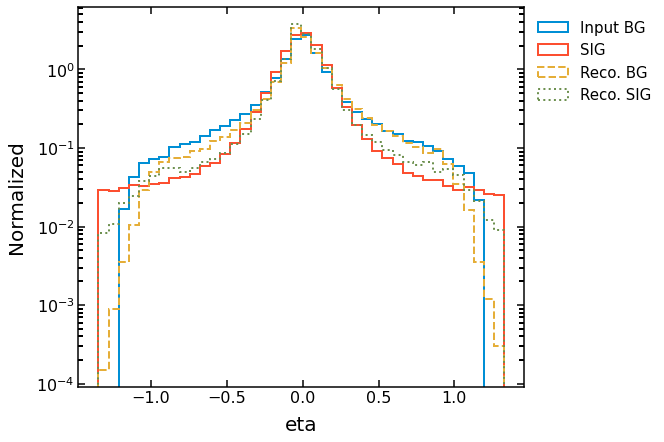

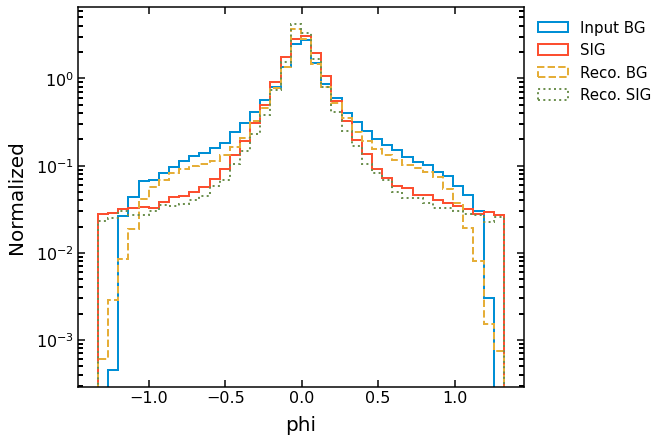

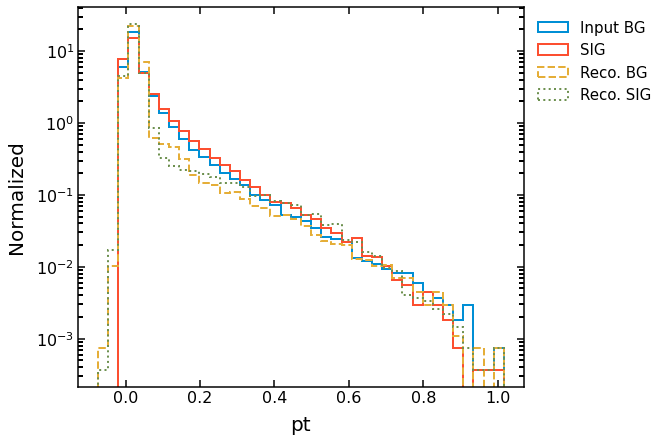

In [19]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(Y_bg_predict[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(Y_bg_predict[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(particles_sig[:,:,i].flatten(), bins=bins, label='SIG',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_sig_predict[:,:,i].flatten(), bins=bins, label='Reco. SIG', linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    plt.show()

In [20]:
sys.path.append(os.path.abspath(os.path.join('../../vande/')))
sys.path.append(os.path.abspath(os.path.join('../../pofah/')))
sys.path.append(os.path.abspath(os.path.join('../../sarewt/')))
sys.path.append(os.path.abspath(os.path.join('../../')))

In [21]:
import vande.analysis.analysis_roc as ar
reload(ar)

<module 'vande.analysis.analysis_roc' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py'>

In [22]:
#neg_class_losses = [loss_bg.tolist(),loss_bg_gnn.tolist(),loss_bg_gvae.tolist()]
#pos_class_losses = [loss_signal.tolist(),loss_signal_gnn.tolist(),loss_signal_gvae.tolist()]
neg_class_losses = [loss_bg.tolist()]
pos_class_losses = [loss_sig.tolist()]

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


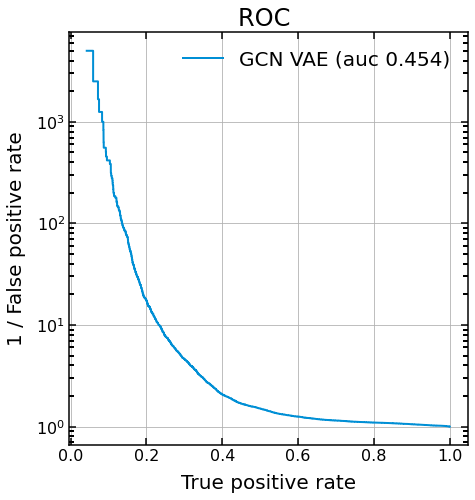

[0.45430612000000004]

In [23]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
#ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE','GAE','GVAE'], title='ROC ',
#            plot_name='ROC_text', fig_dir='figs/',log_x=False )
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE'], title='ROC ',
            plot_name='ROC_gcnvae', fig_dir='',log_x=False )
